# 0.0 Imports

## 0.1 Importando as bibliotecas

In [2]:
import sweetviz 
import pandas   as pd 
import numpy    as np
import seaborn as sns
import math

from matplotlib       import pyplot as plt
from sklearn import preprocessing as pp
from imblearn import combine as c
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import ensemble as en
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import svm
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

#from pandas_profiling import ProfileReport

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 0.2 Carregando os dados

In [3]:
data_raw = pd.read_csv('dados/cardio_train.csv', sep = ';') 

## 0.3 Funções auxiliares

In [4]:
def analise_descritiva(num):   
    # Central Tendency - Mean, Mediana
    ct1 = pd.DataFrame( num.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num.apply( np.median ) ).T

    # Dispersions - Std, Min, Max, Range, Skew, Kurtosis
    d1 = pd.DataFrame( num.apply( np.std ) ).T
    d2 = pd.DataFrame( num.apply( min ) ).T
    d3 = pd.DataFrame( num.apply( max ) ).T
    d4 = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( num.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num.apply( lambda x: x.kurtosis() ) ).T

    # Concatenar
    ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return ct

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def modelo(x, y, model):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Calculate the confusion matrix
    #
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
def analise_de_modelos(x, y, lista):
    precisao = []
    recall = []
    modelo = []
    F1Score = []
    accuracy = []
    
    for model in lista:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        model[1].fit(x_train, y_train)
        y_pred = model[1].predict(x_test)

        # Adicionando os valores na lista
        m = model[0]
        a = accuracy_score(y_test, y_pred)
        r = recall_score(y_test, y_pred)
        p = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        modelo.append(m)
        recall.append(r)
        F1Score.append(f1)
        accuracy.append(a)
        precisao.append(p)
        
    
    aux = {
        'Modelo': modelo,
        'Accuracy': accuracy,
        'Precission': precisao,
        'Recall': recall,
        'F1Score': F1Score}
    
    aux = pd.DataFrame(aux)
        
    return aux

def cross_validation(x, y, ml):
    modelo = ml
    scores = cross_val_score(modelo, x, y, cv=10)
    print(scores)
    print (f'{scores.mean()} +- {scores.std()}')
    
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    # histogram
    num_hist = num_attr.hist( bins=25, figsize=(20,15) );

    # display dataframe
    return m
    
    # display histogram
    return num_hist

# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

# 1.0 Descrição dos dados

In [5]:
df = data_raw

In [6]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.1 Dimensões dos dados

In [7]:
print(f'O número de linhas são: {df.shape[0]}')
print(f'O número de colunas são: {df.shape[1]}')

O número de linhas são: 70000
O número de colunas são: 13


## 1.2 Tipo das colunas

1  - id: Identificação dos exames 
2  - Age: Idade(em dias)
3  - Gender: Sexo
4  - Height: Altura (cm)
5  - Weight: Peso (Kg)
6  - ap_hi: Pressão arterial sistólica
7  - ap_lo: Pressão arterial diastólica
8  - Cholesterol: Colesterol (1: Normal, 2:Acima do normal, 3: Bem acima do normal)
9  - gluc: Glicose (1: Normal, 2: Acima do normal, 3: Bem acima do normal)
10 - smoke: Fumar (1: sim, 2: não)
11 - alco: Uso de álcool (0: Não, 1: Sim)
12 - active: (0: Não, 1:Sim)
13 - cardio: Doente ou não

In [8]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

-> Todas as colunas estão com os valores corretos

## 1.3 Checando NA

In [9]:
df.isna().sum() / len(df)

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64

-> Não existem valores faltantes

## 1.4 Análise descritiva dos dados 

In [10]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )

analise_descritiva(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


## 1.5 Pandas Profile

In [11]:
"""profile = ProfileReport(df, title="doenças cardiovasculares")
profile.to_file("doenças cardiovasculares.html")"""

'profile = ProfileReport(df, title="doenças cardiovasculares")\nprofile.to_file("doenças cardiovasculares.html")'

# 2.0 Feature Enginering

In [12]:
df2 = df

In [13]:
df2.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [14]:
# BMI - Body Mass Index (IMC) = weight/height^2
df2['bmi'] = df2['weight']/((df2['height']/100)**2)

# Systolic and Diastolic blood pressure ratio
df2['bpr'] = df2['ap_hi'] / df2['ap_lo']

# Systolic and Diastolic blood pressure sum
df2['ap_sum'] = df2['ap_hi'] + df2['ap_lo']

# Transformando idade para ano
df2['age_ano'] = (df2['age'] / 365)
df2['age_ano'] = df2['age_ano'].astype(int)

# 3.0 Filtrando os dados

In [15]:
df3 = df2

In [16]:
# Filtrando valores mínimos e máximos de altura
df3 = df3[(df3['height'] >= 145) & (df3['height'] <= 210)]

# Filtrando o peso mínimo
df3 = df3[df3['weight'] >= 40]

# filtrando ap_hi (pressão sistólica) mínima e máxima possível (outliers)
df3 = df3[(df3['ap_hi'] >= 40) & (df3['ap_hi'] <= 200)]

# filtrando ap_lo (pressão diastólica) mínima e máxima possível (outliers)
df3 = df3[(df3['ap_lo'] >= 40) & (df3['ap_lo'] <= 140)]

# Removendo as situações em que a pressão diastólica é maior que a sistólica
df3 = df3[(df3['ap_hi']) > (df3['ap_lo'])]


# 4.0 Análise Exploratória

In [17]:
df4 = df3.copy()

## 4.1 Relatório automatizado

In [18]:
"""# Gerando relatorio  
relatorio = sweetviz.analyze(df4, target_feat='active')
# Gerando o relatorio em html 
relatorio.show_html('relatorio.html')"""

"# Gerando relatorio  \nrelatorio = sweetviz.analyze(df4, target_feat='active')\n# Gerando o relatorio em html \nrelatorio.show_html('relatorio.html')"

## 4.2 Análise Univariada

### 4.2.1 Análise da variável resposta

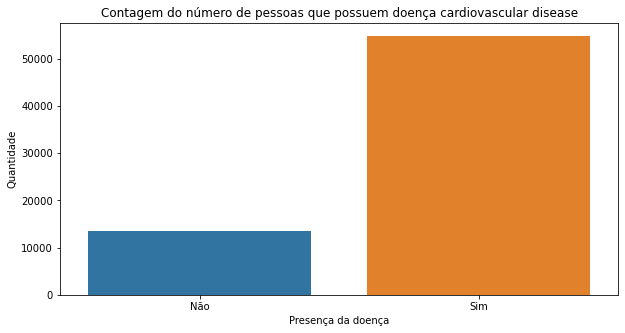

In [19]:
# Definindo tamanho da imagem
plt.figure(figsize=(10,5))

# Contagem dos valores
sns.countplot(x=df4['active']);

# Ajustando o gráfico
plt.title('Contagem do número de pessoas que possuem doença cardiovascular disease');
plt.xlabel('Presença da doença');
plt.ylabel('Quantidade');
plt.xticks(ticks=[0,1], labels=['Não', 'Sim']);

# Plotando o gráfico
plt.show()

### 4.2.2 Plotando o histograma das variáveis

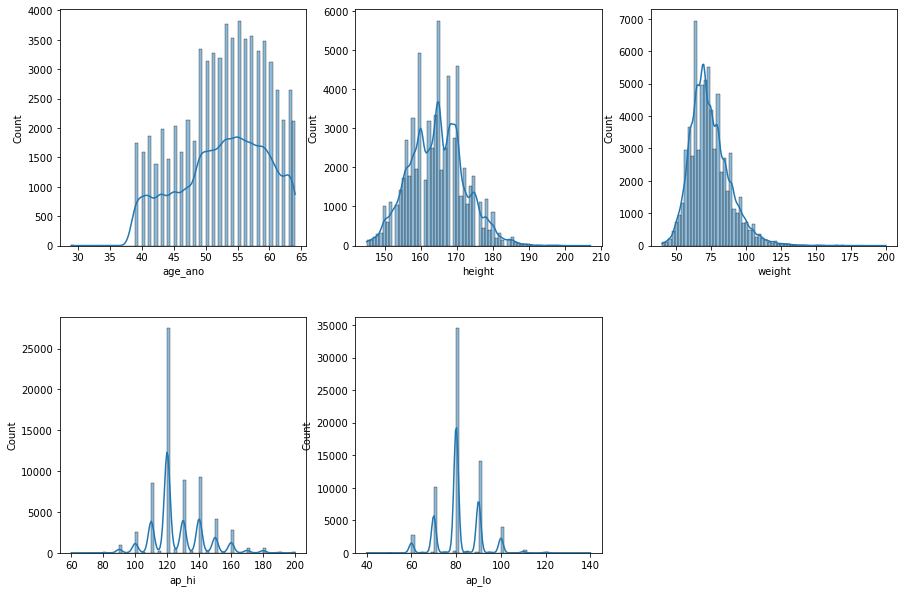

In [20]:
# Defininindo lista 
aux = df4[['age_ano','height','weight','ap_hi','ap_lo']].columns.tolist()

# Definindo tamanho dos gráficos
plt.figure(figsize=(15,10))

# Definindo a constante
x = 1

# Gerando os gráficos
for col in aux:
    plt.subplot(2, 3, x)
    sns.histplot(x=df4[col], bins=70, kde=True);
    x +=1
    
# adjust height reserved for space between subplots  
plt.subplots_adjust(hspace=0.3)

# Plotando
plt.show()

### 4.2.3 Análise das varáveis categóricas

In [21]:
aux = df4[['gender','cholesterol','gluc','smoke','alco']]
aux.head()

,gender,cholesterol,gluc,smoke,alco
0,2,1,1,0,0
1,1,3,1,0,0
2,1,3,1,0,0
3,2,1,1,0,0
4,1,1,1,0,0


In [22]:
# Convertendo sexo em categórico
aux['gender'] = aux['gender'].astype('category')

# Convertendo gluc em categórico
aux['gluc'] = aux['gluc'].apply(lambda x: 'normal' if x == 1 else
                                          'acima do normal' if x == 2 else 
                                          'bem acima do normal')

# Convertendo sexo em categórico
aux['cholesterol'] = aux['cholesterol'].apply(lambda x: 'normal' if x == 1 else
                                          'acima do normal' if x == 2 else 
                                          'bem acima do normal')

# Convertendo smoke em categórico
aux['smoke'] = aux['smoke'].apply(lambda x: 'sim' if x == 1 else 'não')

# Convertendo alco em categórico
aux['alco'] = aux['alco'].apply(lambda x: 'sim' if x == 1 else 'não')

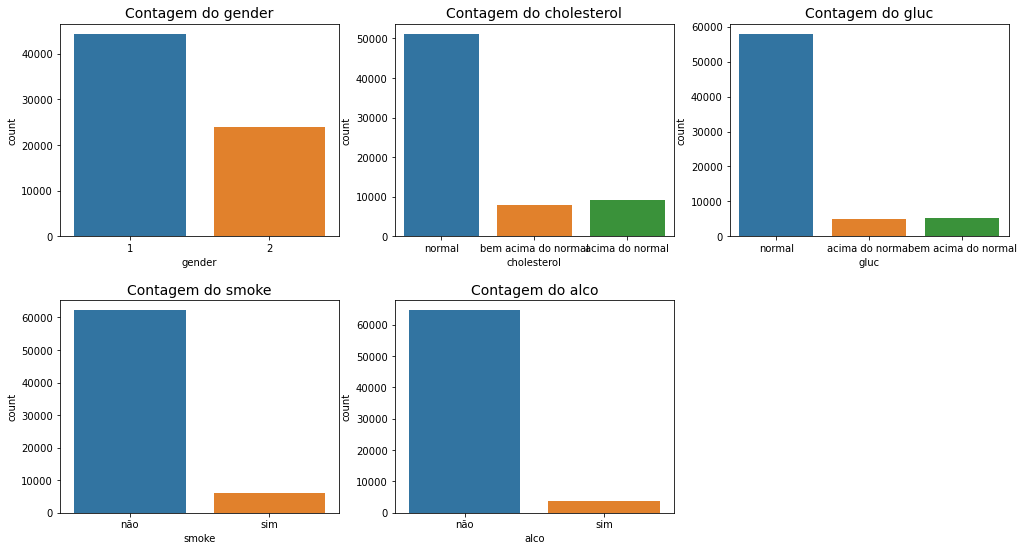

In [23]:
lista = aux.columns.tolist()

plt.figure(figsize=(17,9))

x = 1

for col in lista:
    plt.subplot(2, 3, x)
    sns.countplot(x = aux[col]);
    plt.title("Contagem do " + col, fontsize=14);
    x += 1
    
# adjust height reserved for space between subplots  
plt.subplots_adjust(hspace=0.3)

plt.show()

## 4.3 Análise Bivariada

### Pessoas com mais de 50 anos são mais propensas a terem a doença

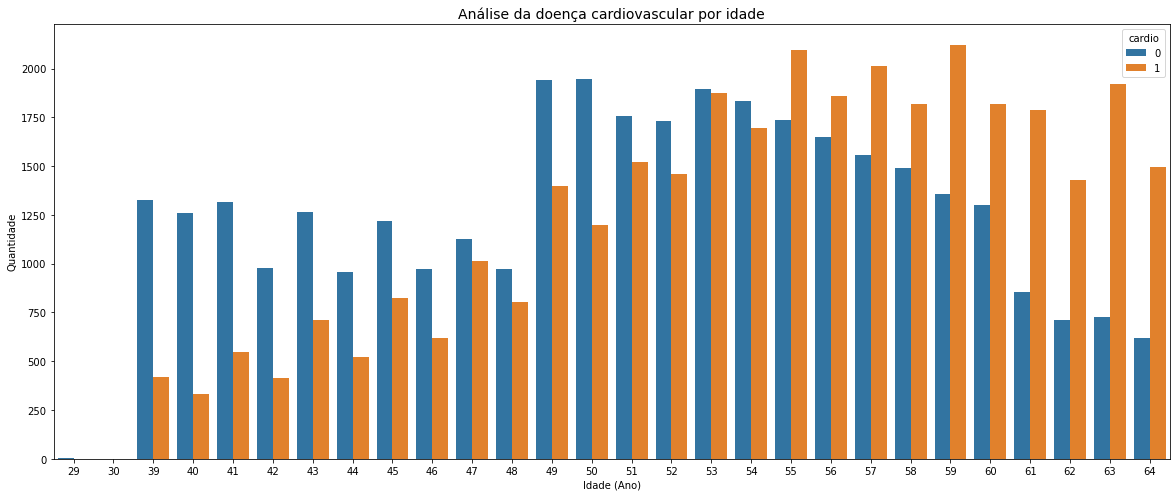

In [24]:
# Dimensão do gráfico
plt.figure(figsize=(20,8))

# Plot do gráfico
sns.countplot(x=df4['age_ano'], hue='cardio', data=df4);

# Configurando o gráfico
plt.title('Análise da doença cardiovascular por idade', fontsize=14);
plt.xlabel('Idade (Ano)');
plt.ylabel('Quantidade');
plt.show()

### Pessoas com colesterol alto tem mais chances de ficar doentes

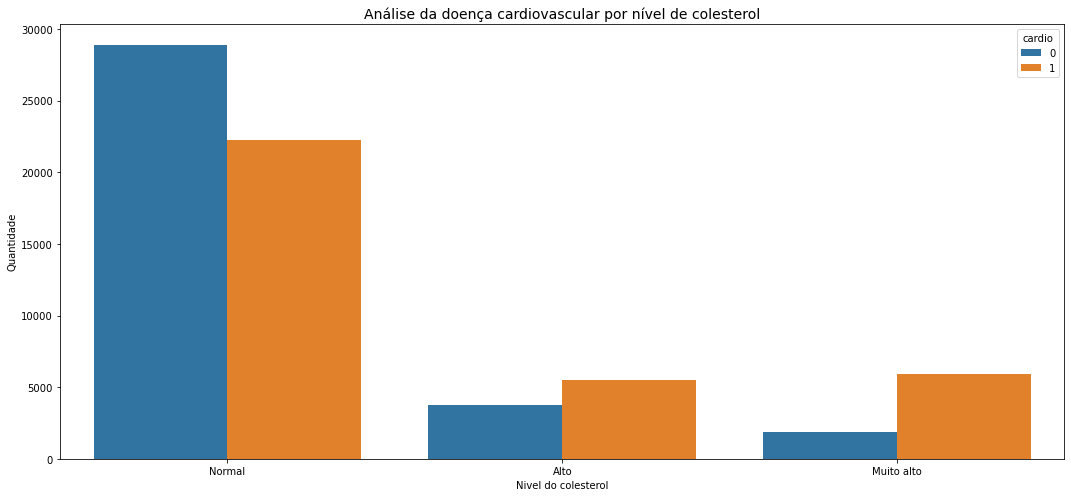

In [25]:
# Definindo dimensões do gráfico
plt.figure(figsize=(18,8))

# Gerando gráfico
sns.countplot(x=df4['cholesterol'], hue='cardio', data=df4);

# Configurando o gráfico
plt.title('Análise da doença cardiovascular por nível de colesterol', fontsize=14);
plt.xlabel('Nivel do colesterol');
plt.ylabel('Quantidade');
plt.xticks(ticks=[0,1,2], labels=['Normal', 'Alto', 'Muito alto'])

plt.show()

### Pessoas que fumam tem mais chances de ficar doentes

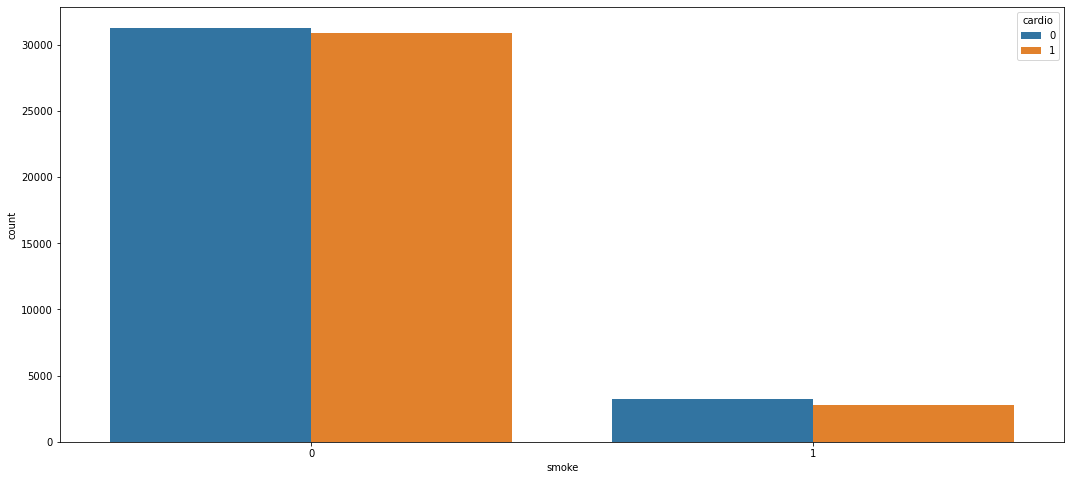

In [26]:
# Definindo dimensões do gráfico
plt.figure(figsize=(18,8))

# Gerando gráfico
sns.countplot(x=df4['smoke'], hue='cardio', data=df4);

# 5.0 Preparação dos dados

In [27]:
df5 = df4.copy()

In [28]:
df5.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
bmi            float64
bpr            float64
ap_sum           int64
age_ano          int32
dtype: object

In [29]:
df5 = df5.drop(['id'], axis = 1)

In [30]:
df51 = df5.drop(['cardio'], axis=1)
# define sampler
smt = c.SMOTETomek( sampling_strategy='auto', random_state=32, n_jobs=-1 )

# apply sampler
x_smt, y_smt = smt.fit_resample(df51, df5['cardio'] )

df5 = pd.concat([x_smt, y_smt], axis=1)

In [31]:
df5

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,bpr,ap_sum,age_ano,cardio
0,18393,2,168,62.000000,110,80,1,1,0,0,1,21.967120,1.375000,190,50,0
1,18857,1,165,64.000000,130,70,3,1,0,0,0,23.507805,1.857143,200,51,1
2,17623,2,169,82.000000,150,100,1,1,0,0,1,28.710479,1.500000,250,48,1
3,17474,1,156,56.000000,100,60,1,1,0,0,0,23.011177,1.666667,160,47,0
4,21914,1,151,67.000000,120,80,2,2,0,0,0,29.384676,1.500000,200,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56049,18837,1,166,70.240014,120,80,1,1,0,0,1,25.458940,1.500000,200,51,1
56050,20179,1,163,76.478188,130,86,1,1,0,0,0,28.784745,1.511168,216,55,1
56051,21930,1,157,76.704991,120,80,1,1,0,0,1,31.118906,1.500000,200,60,1
56052,23340,1,168,73.485654,120,80,1,1,0,0,1,26.042713,1.500000,200,63,1


In [32]:
mms_age = pp.MinMaxScaler()
mms_height = pp.MinMaxScaler()
mms_weight = pp.MinMaxScaler()
mms_ap_hi = pp.MinMaxScaler()
mms_ap_lo = pp.MinMaxScaler()
mms_bmi = pp.MinMaxScaler()
mms_bpr = pp.MinMaxScaler()
mms_ap_sum = pp.MinMaxScaler()


df5['age'] = mms_age.fit_transform(df5[['age']].values)
df5['height'] = mms_height.fit_transform(df5[['height']].values)
df5['weight'] = mms_weight.fit_transform(df5[['weight']].values)
df5['ap_hi'] = mms_ap_hi.fit_transform(df5[['ap_hi']].values)
df5['ap_lo'] = mms_ap_lo.fit_transform(df5[['ap_lo']].values)
df5['bmi'] = mms_bmi.fit_transform(df5[['bmi']].values)
df5['bpr'] = mms_bpr.fit_transform(df5[['bpr']].values)
df5['ap_sum'] = mms_ap_lo.fit_transform(df5[['ap_sum']].values)

In [33]:
# Convertendo sexo em categórico
df5['gender'] = df5['gender'].astype('category')

# Convertendo gluc em categórico
df5['gluc'] = df5['gluc'].apply(lambda x: 'normal' if x == 1 else
                                          'acima do normal' if x == 2 else 
                                          'bem acima do normal')

# Convertendo sexo em categórico
df5['cholesterol'] = df5['cholesterol'].apply(lambda x: 'normal' if x == 1 else
                                          'acima do normal' if x == 2 else 
                                          'bem acima do normal')

# Convertendo smoke em categórico
df5['smoke'] = df5['smoke'].apply(lambda x: 'sim' if x == 1 else 'não')

# Convertendo alco em categórico
df5['alco'] = df5['alco'].apply(lambda x: 'sim' if x == 1 else 'não')

In [34]:
df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'] )

df5 = pd.get_dummies( df5, prefix='gluc', columns=['gluc'] )

df5 = pd.get_dummies( df5, prefix='cholesterol', columns=['cholesterol'] )

df5 = pd.get_dummies( df5, prefix='smoke', columns=['smoke'] )

df5 = pd.get_dummies( df5, prefix='alco', columns=['alco'] )



In [35]:
df5.head()

,age,height,weight,ap_hi,ap_lo,active,bmi,bpr,ap_sum,age_ano,...,gluc_acima do normal,gluc_bem acima do normal,gluc_normal,cholesterol_acima do normal,cholesterol_bem acima do normal,cholesterol_normal,smoke_não,smoke_sim,alco_não,alco_sim
0,0.588076,0.370968,0.13750,0.357143,0.4,1,0.154165,0.107500,0.375000,50,...,0,0,1,0,0,1,1,0,1,0
1,0.624003,0.322581,0.15000,0.500000,0.3,0,0.182286,0.271429,0.416667,51,...,0,0,1,0,1,0,1,0,1,0
2,0.528455,0.387097,0.26250,0.642857,0.6,1,0.277247,0.150000,0.625000,48,...,0,0,1,0,0,1,1,0,1,0
3,0.516918,0.177419,0.10000,0.285714,0.2,0,0.173221,0.206667,0.250000,47,...,0,0,1,0,0,1,1,0,1,0
4,0.860705,0.096774,0.16875,0.428571,0.4,0,0.289552,0.150000,0.416667,60,...,1,0,0,1,0,0,1,0,1,0


# 6.0 Feature Selection

In [36]:
df6 = df5

In [37]:
df6.isna().sum()

age                                0
height                             0
weight                             0
ap_hi                              0
ap_lo                              0
active                             0
bmi                                0
bpr                                0
ap_sum                             0
age_ano                            0
cardio                             0
gender_1                           0
gender_2                           0
gluc_acima do normal               0
gluc_bem acima do normal           0
gluc_normal                        0
cholesterol_acima do normal        0
cholesterol_bem acima do normal    0
cholesterol_normal                 0
smoke_não                          0
smoke_sim                          0
alco_não                           0
alco_sim                           0
dtype: int64

Feature ranking:
                           feature  importance
0                              age    0.224237
0                              bmi    0.129984
0                            ap_hi    0.122239
0                           weight    0.115699
0                           ap_sum    0.115469
0                           height    0.108298
0                            ap_lo    0.061884
0                              bpr    0.035646
0               cholesterol_normal    0.023248
0  cholesterol_bem acima do normal    0.019774
0                           active    0.009576
0      cholesterol_acima do normal    0.005214
0                      gluc_normal    0.005005
0                         gender_2    0.003852
0                         gender_1    0.003843
0         gluc_bem acima do normal    0.003281
0             gluc_acima do normal    0.002862
0                        smoke_sim    0.002593
0                        smoke_não    0.002563
0                         alco_sim    0.002

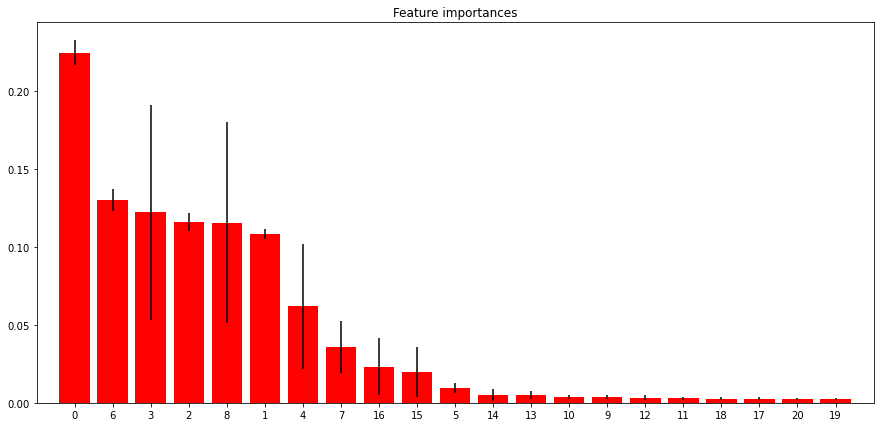

In [38]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
y_train_n = df6[['cardio']].values
x_train_n = df6.drop(['cardio', 'age_ano'], axis=1)
forest.fit( x_train_n, y_train_n )

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [39]:
colunas = ['age', 'weight', 'ap_hi', 'ap_lo', 'height', ]

# 7.0 Machine Learning

In [40]:
df7 = df6.copy()

In [41]:
x = df7.drop(['cardio', 'age_ano'], axis=1)
y = df7[['cardio']]

## 7.1 Visão geral

In [42]:
lista = [
    ['KNN', KNeighborsClassifier(n_neighbors=10)],
    ['LogisticRegression', LogisticRegression()],
    ['ExtraTrees', en.ExtraTreesClassifier( n_estimators=300, n_jobs=-1, random_state=32 )],
    ['Gaussian', GaussianNB()],
    ['RandomForest', en.RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=32)],
    ['XgBoost', xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, n_estimators=300, n_jobs=-1, random_state=32)],
]


In [43]:
analise_de_modelos(x,y,lista)

[14:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,Modelo,Accuracy,Precission,Recall,F1Score
0,KNN,0.764307,0.803398,0.703956,0.750397
1,LogisticRegression,0.776795,0.803866,0.731237,0.765833
2,ExtraTrees,0.754674,0.754098,0.748883,0.751482
3,Gaussian,0.741330,0.781181,0.664364,0.718052
4,RandomForest,0.767518,0.776985,0.748282,0.762363
5,XgBoost,0.773726,0.795219,0.740956,0.767129


## KNN

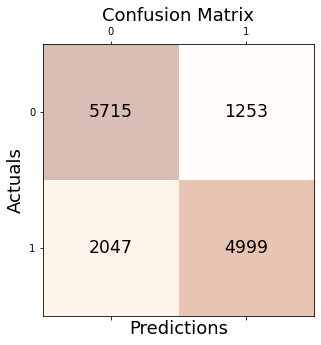

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      6968
           1       0.80      0.71      0.75      7046

    accuracy                           0.76     14014
   macro avg       0.77      0.76      0.76     14014
weighted avg       0.77      0.76      0.76     14014



In [44]:
model = KNeighborsClassifier(n_neighbors=10)
modelo(x, y, model)


## ExtraTree

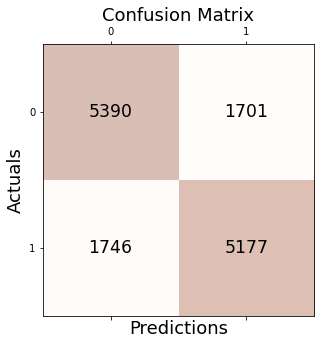

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      7091
           1       0.75      0.75      0.75      6923

    accuracy                           0.75     14014
   macro avg       0.75      0.75      0.75     14014
weighted avg       0.75      0.75      0.75     14014



In [46]:
model = en.ExtraTreesClassifier( n_estimators=300, n_jobs=-1, random_state=32 )
modelo(x, y, model)

## Gaussian

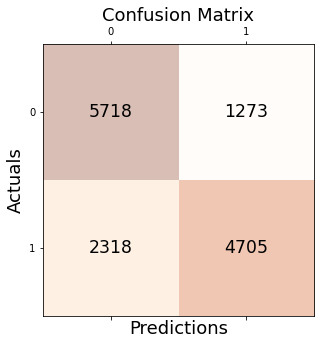

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      6991
           1       0.79      0.67      0.72      7023

    accuracy                           0.74     14014
   macro avg       0.75      0.74      0.74     14014
weighted avg       0.75      0.74      0.74     14014



In [47]:
model = GaussianNB()
modelo(x, y, model)

## XgBoost

[14:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


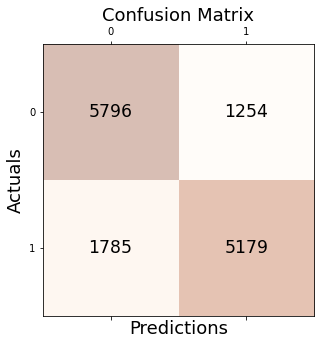

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      7050
           1       0.81      0.74      0.77      6964

    accuracy                           0.78     14014
   macro avg       0.78      0.78      0.78     14014
weighted avg       0.78      0.78      0.78     14014



In [48]:
model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, n_estimators=300, n_jobs=-1, random_state=32 )
modelo(x, y, model)

## RandomForest

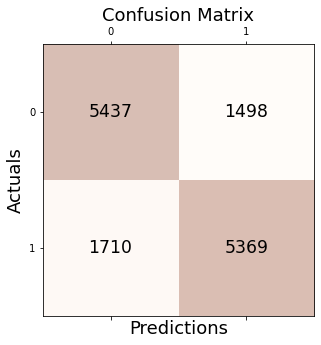

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6935
           1       0.78      0.76      0.77      7079

    accuracy                           0.77     14014
   macro avg       0.77      0.77      0.77     14014
weighted avg       0.77      0.77      0.77     14014



In [49]:
model = en.RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=32)
modelo(x, y, model)

## LGBM

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


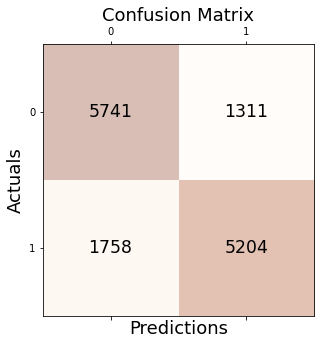

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      7052
           1       0.80      0.75      0.77      6962

    accuracy                           0.78     14014
   macro avg       0.78      0.78      0.78     14014
weighted avg       0.78      0.78      0.78     14014



In [50]:
model = LGBMClassifier(colsample_bytree=0.55, learning_rate=0.04378571428571428,
                       max_depth=10, min_data_in_leaf=400, num_leaves=64,
                       random_state=42, subsample=0.8392857142857143, n_jobs=-1)
modelo(x, y, model)